In [1]:
## importing important libraries
import matplotlib
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
# import warnings; warnings.simplefilter('ignore', category=FutureWarning)
# import warnings; warnings.simplefilter('ignore')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("C:\\Users\\Acer\\Desktop\\dataset_full.csv")
data.head()

qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   
1                    0              0  ...                1                2   
2                    0              0  ...                1                2   
3                    0              0  ...                1                2   
4                    0              0  ...                1                2   

   qty_mx_servers  ttl_hostname  tls_ssl_certificate  qty_redirects  \
0               0           892                    0              0   
1               1          9540                    1              0   
2               3           589                    1              0   
3               0           292                    1              0   
4               1          3597                    0              1   

   url_google_index  domain_google_index  url_shortened  phishing  
0                 0                    0              0         1  
1                 0                    0              0         1  
2                 0                    0              0         0  
3                 0                    0              0         1  
4                 0                    0              0         0  

[5 rows x 112 columns]

<AxesSubplot:xlabel='phishing', ylabel='count'>

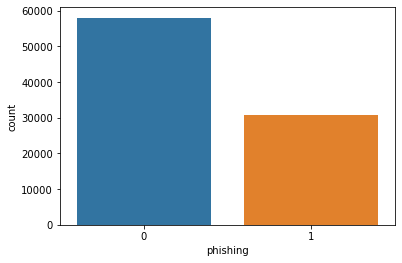

In [22]:
sns.countplot(data["phishing"])

In [23]:
data["phishing"].value_counts()

0    58000
1    30647
Name: phishing, dtype: int64

#### Observation:
The data set is balanced dataset with high dimension

## Selecting Important Feature

In [24]:
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV

In [25]:
xTrain,xTemp,yTrain,yTemp=train_test_split(data.drop('phishing',axis=1),data['phishing'],test_size=0.4,random_state=105)
xValidate,xTest,yValidate,yTest=train_test_split(xTemp,yTemp,test_size=0.5,random_state=42)

In [26]:
# xTest.to_csv('C:\\Users\\Acer\\Desktop\\file.csv')

 ### Bayesian Optimization with LightGBM

In [27]:
%%time
# run block of code and catch warnings
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    # execute code that will generate warnings
    def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
        # prepare data
        train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
        # parameters
        def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
            params = {'application':'binary', 'metric':'auc'}
            params['learning_rate'] = max(min(learning_rate, 1), 0)
            params["num_leaves"] = int(round(num_leaves))
            params['feature_fraction'] = max(min(feature_fraction, 1), 0)
            params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
            params['max_depth'] = int(round(max_depth))
            params['max_bin'] = int(round(max_depth))
            params['min_data_in_leaf'] = int(round(min_data_in_leaf))
            params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
            params['subsample'] = max(min(subsample, 1), 0)
            
            cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
            return max(cv_result['auc-mean'])
        
        lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                                'num_leaves': (24, 80),
                                                'feature_fraction': (0.1, 0.9),
                                                'bagging_fraction': (0.8, 1),
                                                'max_depth': (5, 30),
                                                'max_bin':(20,90),
                                                'min_data_in_leaf': (20, 80),
                                                'min_sum_hessian_in_leaf':(0,100),
                                            'subsample': (0.01, 1.0)}, random_state=200)

        
        #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
        #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
        
        lgbBO.maximize(init_points=init_round, n_iter=opt_round)
        
        model_auc=[]
        for model in range(len( lgbBO.res)):
            model_auc.append(lgbBO.res[model]['target'])
        
        # return best parameters
        return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

    opt_params = bayes_parameter_opt_lgb(xTrain, yTrain, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Info] Number of positive: 12316, number of negative: 23142
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

In [28]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.8140921754923061,
 'feature_fraction': 0.6431267528992862,
 'learning_rate': 0.2856236274471721,
 'max_bin': 46,
 'max_depth': 28,
 'min_data_in_leaf': 29,
 'min_sum_hessian_in_leaf': 18.749171152949586,
 'num_leaves': 71,
 'subsample': 0.1965786250154723,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

### Training LightGBM

In [29]:
target=yTrain
features= [c for c in xTrain.columns if c not in ['target']]

In [30]:
%%time 

target=yTrain
features= [c for c in xTrain.columns if c not in ['target']]


folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(xTrain))
predictions = np.zeros(len(xValidate))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xTrain.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(xTrain.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(xTrain.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(xTrain.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(xValidate[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
[LightGBM] [Warning] bagging_fraction is set=0.8140921754923061, subsample=0.1965786250154723 will be ignored. Current value: bagging_fraction=0.8140921754923061
[LightGBM] [Warning] bagging_fraction is set=0.8140921754923061, subsample=0.1965786250154723 will be ignored. Current value: bagging_fraction=0.8140921754923061
[LightGBM] [Info] Number of positive: 16627, number of negative: 31242
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 47869, number of used features: 95
[LightGBM] [Warning] bagging_fraction is set=0.8140921754923061, subsample=0.1965786250154723 will be ignored. Current value: bagging_fraction=0.8140921754923061
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warnin

In [31]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
imp_feature=best_features.sort_values('importance', ascending=False)[:40]

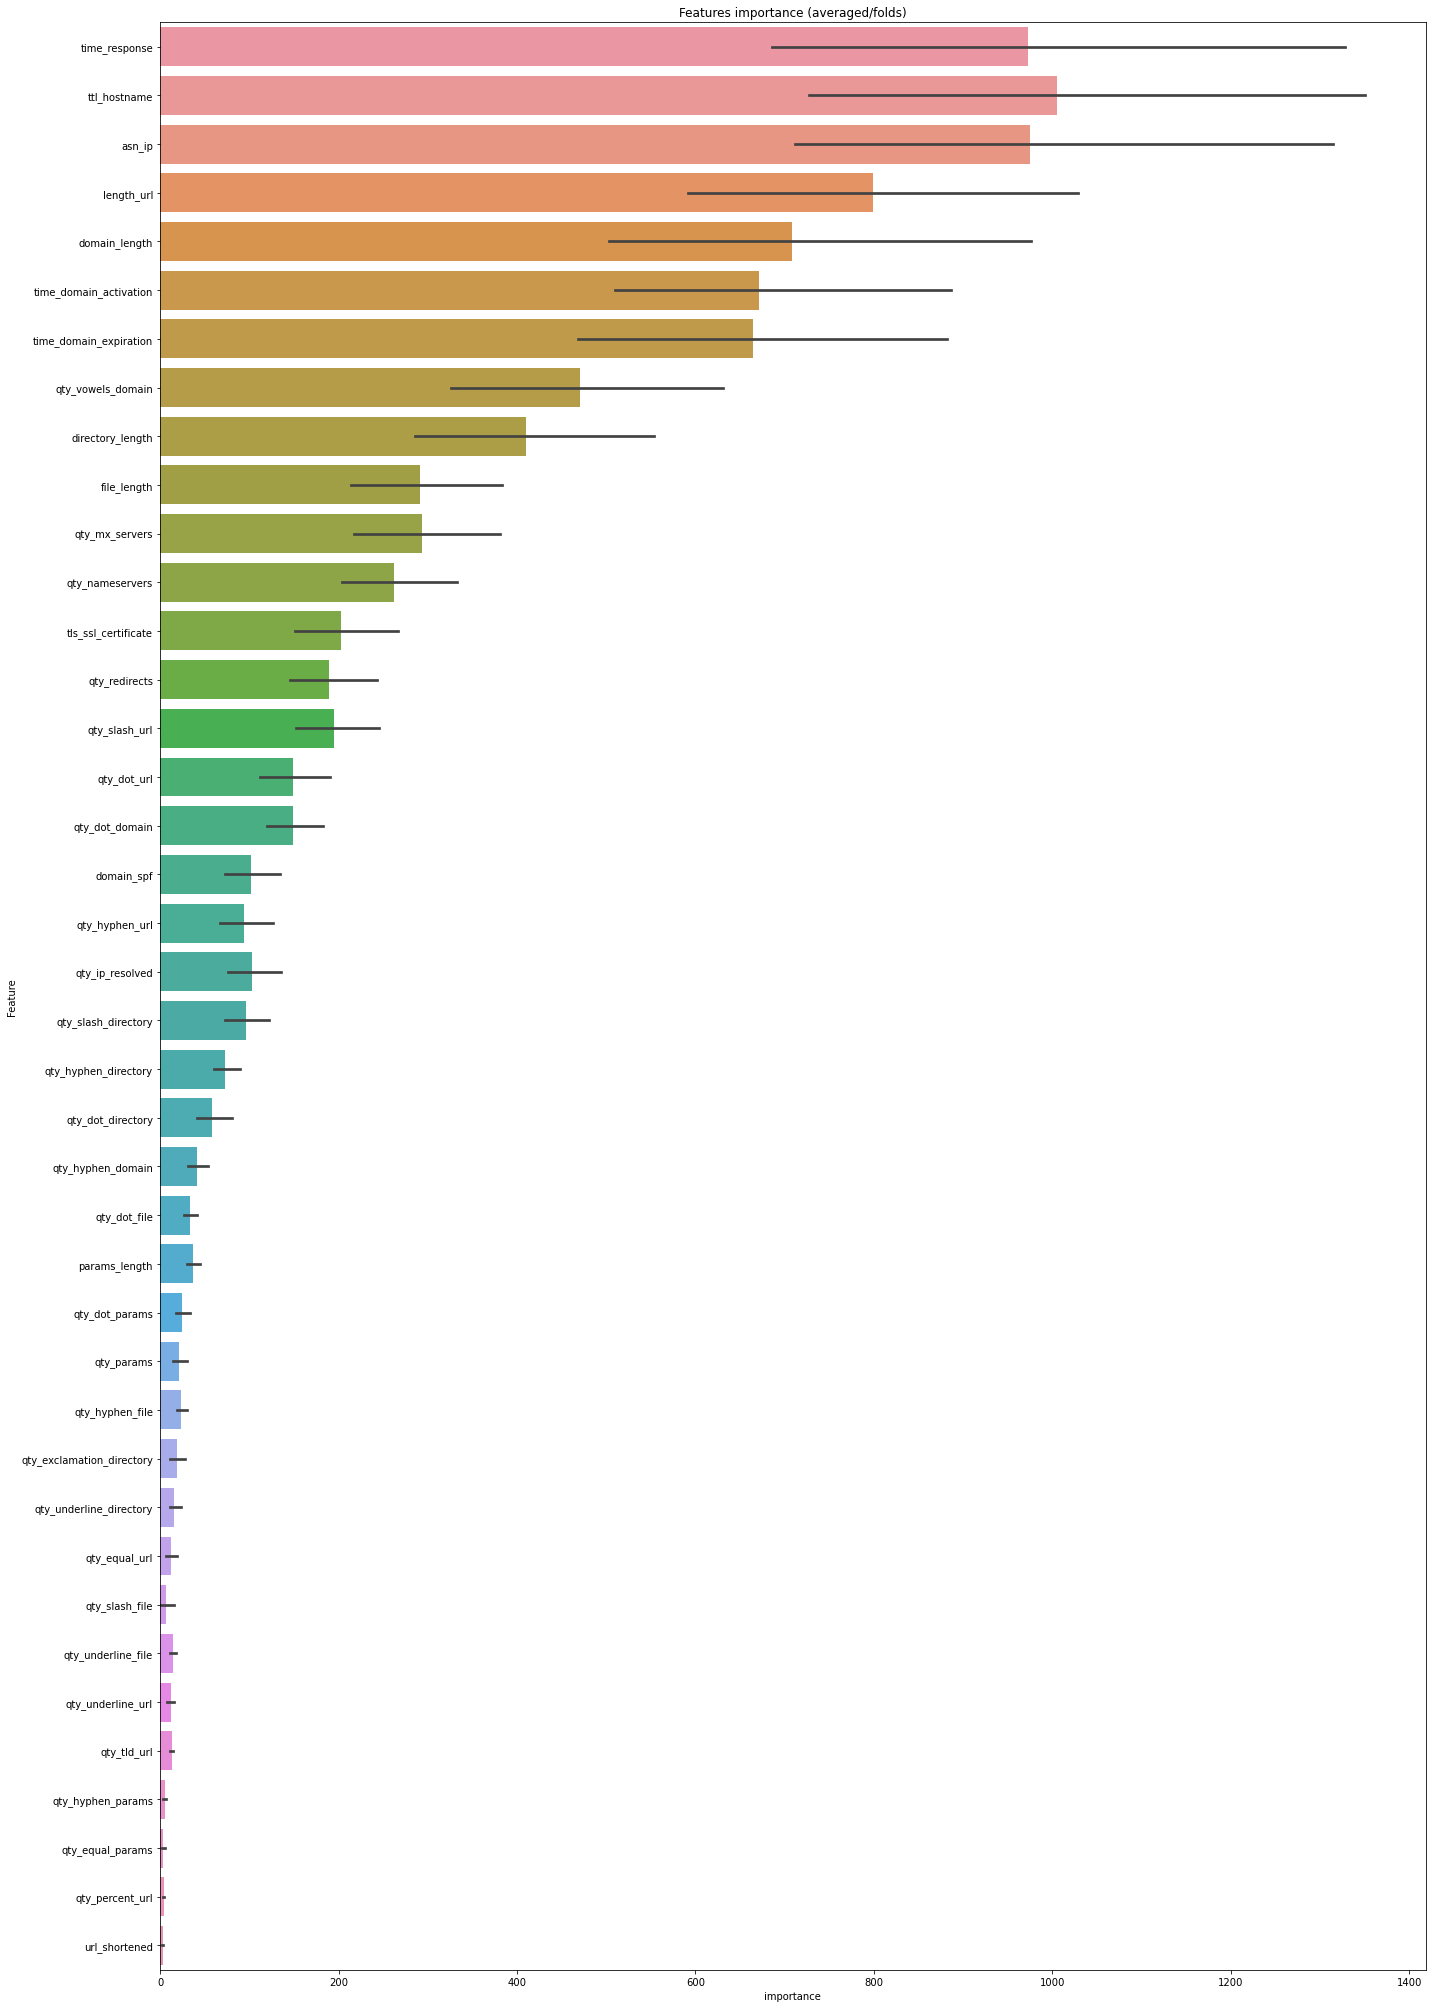

In [32]:
plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance.png')

In [33]:
#for top important feature
imp_feature=imp_feature.Feature.unique()
imp_feature

array(['time_response', 'ttl_hostname', 'asn_ip', 'length_url',
       'domain_length', 'time_domain_activation',
       'time_domain_expiration', 'qty_vowels_domain', 'directory_length'],
      dtype=object)

In [34]:
# imp_feature=['time_response', 'ttl_hostname', 'asn_ip', 'length_url',
#        'domain_length', 'time_domain_activation',
#        'time_domain_expiration', 'qty_vowels_domain', 'directory_length']

In [35]:
imp_feature.shape

(9,)

There are only nine feature the target variable depend

In [36]:
df=data[imp_feature]
df.head()

time_response  ttl_hostname  asn_ip  length_url  domain_length  \
0       0.207316           892   60781          25             17   
1       0.499566          9540   36024         223             16   
2       0.935901           589    4766          15             14   
3       0.410021           292   20454          81             19   
4       0.410761          3597   53831          19             19   

   time_domain_activation  time_domain_expiration  qty_vowels_domain  \
0                      -1                      -1                  4   
1                     579                     150                  5   
2                      -1                      -1                  3   
3                      -1                      -1                  7   
4                    6998                     306                  5   

   directory_length  
0                 8  
1                42  
2                 1  
3                62  
4                -1

In [37]:
df=pd.concat([df,data.phishing],axis=1)

In [38]:
df.head()

time_response  ttl_hostname  asn_ip  length_url  domain_length  \
0       0.207316           892   60781          25             17   
1       0.499566          9540   36024         223             16   
2       0.935901           589    4766          15             14   
3       0.410021           292   20454          81             19   
4       0.410761          3597   53831          19             19   

   time_domain_activation  time_domain_expiration  qty_vowels_domain  \
0                      -1                      -1                  4   
1                     579                     150                  5   
2                      -1                      -1                  3   
3                      -1                      -1                  7   
4                    6998                     306                  5   

   directory_length  phishing  
0                 8         1  
1                42         1  
2                 1         0  
3                62         1  
4                -1         0

In [39]:
xTrain,xTemp,yTrain,yTemp=train_test_split(df.drop('phishing',axis=1),data['phishing'],test_size=0.4,random_state=105)
xValidate,xTest,yValidate,yTest=train_test_split(xTemp,yTemp,test_size=0.5,random_state=42)

In [40]:
# sns.pairplot(df,hue='phishing')

In [41]:
model = RandomForestClassifier(random_state=105)
model.fit(xTrain, yTrain)
preds = model.predict(xTest)

In [42]:
accuracy = metrics.accuracy_score(yTest, preds)
print(accuracy)

0.9642413987591653


In [43]:
metrics.confusion_matrix(yTest, preds)

array([[11245,   350],
       [  284,  5851]], dtype=int64)

In [44]:
from lightgbm import LGBMClassifier

In [45]:
model2=LGBMClassifier()

In [46]:
model2.fit(xTrain,yTrain)
pred2=model2.predict(xTest)
accuracy = metrics.accuracy_score(yTest, pred2)
print(accuracy)

0.9570783981951495


In [47]:
from xgboost import XGBClassifier
model3=XGBClassifier()

In [48]:
model3.fit(xTrain,yTrain)
pred2=model3.predict(xTest)
accuracy = metrics.accuracy_score(yTest, pred2)
print(accuracy)

0.9620417371686407


Since LightGB with proper tuned will a better option for random forest. I go with LightGB

In [49]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [50]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(xValidate,yValidate)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

Set up HyperParameter search

In [51]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [52]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 7 #000 #3000

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=105, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=105,
    verbose=True)

In [53]:
gs.fit(xTrain, yTrain, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 7000 candidates, totalling 21000 fits
[100]	valid's auc: 0.989955
[200]	valid's auc: 0.991481
[300]	valid's auc: 0.991952
[400]	valid's auc: 0.992234
[500]	valid's auc: 0.992369
[100]	valid's auc: 0.989567
[200]	valid's auc: 0.991169
[300]	valid's auc: 0.991604
[400]	valid's auc: 0.99183
[100]	valid's auc: 0.99014
[200]	valid's auc: 0.991498
[300]	valid's auc: 0.99197
[400]	valid's auc: 0.99221
[500]	valid's auc: 0.992344
[600]	valid's auc: 0.992413
[100]	valid's auc: 0.988593
[200]	valid's auc: 0.990388
[300]	valid's auc: 0.990937
[400]	valid's auc: 0.991351
[500]	valid's auc: 0.991567
[600]	valid's auc: 0.991685
[700]	valid's auc: 0.991781
[800]	valid's auc: 0.991853
[900]	valid's auc: 0.991881
[1000]	valid's auc: 0.991894
[100]	valid's auc: 0.988446
[200]	valid's auc: 0.990144
[300]	valid's auc: 0.990727
[400]	valid's auc: 0.991108
[500]	valid's auc: 0.991287
[600]	valid's auc: 0.991406
[700]	valid's auc: 0.991489
[800]	valid's auc: 0.991527
[900]	valid's

In [54]:
opt_parameters = gs.best_params_
opt_parameters

{'colsample_bytree': 0.5227922055085975,
 'min_child_samples': 128,
 'min_child_weight': 0.1,
 'num_leaves': 44,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.3020011929283253}

In [55]:
#Configure from the HP optimisation
clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(xTrain, yTrain, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

[100]	valid's auc: 0.991895
[200]	valid's auc: 0.992719
[300]	valid's auc: 0.993014
[400]	valid's auc: 0.993134
[500]	valid's auc: 0.993205
[600]	valid's auc: 0.993247
[700]	valid's auc: 0.993271
[800]	valid's auc: 0.993285
[900]	valid's auc: 0.993295
[1000]	valid's auc: 0.993301
[1100]	valid's auc: 0.993307
[1200]	valid's auc: 0.993313
[1300]	valid's auc: 0.993318
[1400]	valid's auc: 0.993324
[1500]	valid's auc: 0.993329
[1600]	valid's auc: 0.993336
[1700]	valid's auc: 0.993343
[1800]	valid's auc: 0.993347
[1900]	valid's auc: 0.993352
[2000]	valid's auc: 0.993357
[2100]	valid's auc: 0.993362
[2200]	valid's auc: 0.993368
[2300]	valid's auc: 0.993372
[2400]	valid's auc: 0.993377
[2500]	valid's auc: 0.993381
[2600]	valid's auc: 0.993386
[2700]	valid's auc: 0.993391
[2800]	valid's auc: 0.993397
[2900]	valid's auc: 0.993403
[3000]	valid's auc: 0.993407
[3100]	valid's auc: 0.993412
[3200]	valid's auc: 0.993416
[3300]	valid's auc: 0.99342
[3400]	valid's auc: 0.993426
[3500]	valid's auc: 0.99

LGBMClassifier(colsample_bytree=0.5227922055085975, metric='None',
               min_child_samples=128, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=44, random_state=105, reg_alpha=0.1,
               reg_lambda=0.1, silent=True, subsample=0.3020011929283253)

In [56]:
pred=clf_final.predict(xTest)
accuracy = metrics.accuracy_score(yTest, pred)
print(accuracy)

0.9626057529610829


In [57]:
xTest.shape

(17730, 9)

In [58]:
# model=LGBMClassifier(colsample_bytree=0.457110915197301, metric='None',
#                min_child_samples=118, min_child_weight=1, n_estimators=5000,
#                n_jobs=4, num_leaves=46, random_state=105, reg_alpha=0,
#                reg_lambda=0, silent=True, subsample=0.4342036058048952)

In [59]:
# model.fit(xTrain,yTrain)

In [60]:
# pred=model.predict(xTest)
# accuracy = metrics.accuracy_score(yTest, pred)
# print(accuracy)

In [61]:
import pickle

In [65]:
# Saving the final model in form of pickle file
file=open('F:\\1.Study Materials\kaggel\project\model.pkl','wb')
pickle.dump(clf_final,file)
file.close()

In [66]:
# Importing the saved pickle model
file1=open('F:\\1.Study Materials\kaggel\project\model.pkl','rb')
mdl=pickle.load(file1)
file1.close()

In [67]:
# Testing model
pred=mdl.predict(xTest)
accuracy = metrics.accuracy_score(yTest, pred)
print(accuracy)

0.9626057529610829


In [69]:
pred=mdl.predict(xValidate)
accuracy = metrics.accuracy_score(yValidate, pred)
print(accuracy)

0.9646906198883186
